# Imports

In [1]:
# Imports
# import autograd.numpy as np
from autograd import grad
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import CLD_CONTINUED
import warnings
import numpy as np
from scipy.optimize import basinhopping
from sklearn.metrics._plot.confusion_matrix import unique_labels

from scipy.optimize import OptimizeWarning

np.seterr(over="ignore")
np.seterr(invalid="ignore")
warnings.filterwarnings("ignore", category=OptimizeWarning)

# Loading files

In [2]:
# Use pandas to read the CSV file directly from the URL
training_df = pd.read_csv("data/svg_extracted_data.csv")
model_sizes = pd.read_csv(
    "chinchilla_corrections.csv",
    header=1,  # Use first row as headers
    thousands=",",
    dtype=None,
)  # Speed up date parsing

# The DataFrame 'training_df' now contains the data from the CSV file

training_df["Training Tokens"] = training_df["Training FLOP"] / (
    6.0 * training_df["Model Size"]
)
training_df = training_df[
    ["Model Size", "Training Tokens", "Training FLOP", "loss"]
].dropna()

In [3]:
training_df["rounded_ms"] = round(training_df["Model Size"] / 1e6)
training_df["rounded_ms"] = training_df["rounded_ms"].astype(int)

In [4]:
model_sizes.head(5)

,d_model,ffw_size,kv_size,n_heads,n_layers,Vocab Size,Embedding Parameters,KQV Params Per Layer,Output Proj Params Per Layer,Total Attn Params,...,Gated Params Per Layer,Total Gated Params,Reported Parameters (M),"Tied (Un)Embed, No Gating","Untied (Un)Embed, No Gating","Untied (Un)Embed, Gating","Untied (Un)Embed, Gating, Shared KV","Tied (Un)Embed, No Gating, Incorrect Attn Params Prefactor",Signed Relative Error Correct to Reported (%),Signed Relative Error Incorrect to Reported (%)
0,512,2048,64,8,8,32168,16470016,786432,262144,8388608,...,3145728,25165824,44,42,58,66,64.397312,44,5.37,0.61
1,576,2304,64,9,9,32168,18528768,995328,331776,11943936,...,3981312,35831808,57,54,73,85,81.847296,57,4.63,-0.61
2,640,2560,64,10,10,32168,20587520,1228800,409600,16384000,...,4915200,49152000,74,70,90,107,102.615040,74,5.76,0.22
3,640,2560,64,10,13,32168,20587520,1228800,409600,21299200,...,4915200,63897600,90,84,105,126,121.047040,90,6.13,0.21
4,640,2560,64,10,16,32168,20587520,1228800,409600,26214400,...,4915200,78643200,106,99,120,146,139.479040,106,6.39,0.20


In [5]:
# check that the numbers match what's in Rylan's dataframe
training_df.sort_values(by="Model Size").head(10)

,Model Size,Training Tokens,Training FLOP,loss,rounded_ms
46,5.733420e+07,1.686018e+10,5.799989e+18,3.160113,57
47,7.382467e+07,3.154403e+09,1.397237e+18,3.405928,74
45,7.382467e+07,1.302576e+10,5.769736e+18,3.094521,74
94,7.382467e+07,6.525601e+09,2.890502e+18,3.222268,74
196,7.382469e+07,2.518134e+10,1.115403e+19,3.048505,74
136,7.382469e+07,1.188932e+10,5.266353e+18,3.108465,74
49,8.981821e+07,3.276304e+09,1.765630e+18,3.325255,90
95,8.981828e+07,6.531630e+09,3.519959e+18,3.183878,90
137,8.981834e+07,1.267339e+10,6.829816e+18,3.048505,90
82,1.058118e+08,1.370866e+10,8.703231e+18,2.998680,106


In [6]:
model_sizes["Reported Parameters (M)"] = model_sizes["Reported Parameters (M)"].astype(
    int
)

In [7]:
training_df = training_df.merge(
    model_sizes, left_on="rounded_ms", right_on="Reported Parameters (M)"
)

In [8]:
training_df["old_ms"] = training_df["Model Size"]

In [9]:
training_df.columns

Index(['Model Size', 'Training Tokens', 'Training FLOP', 'loss', 'rounded_ms',
       'd_model', 'ffw_size', 'kv_size', 'n_heads', 'n_layers', 'Vocab Size',
       'Embedding Parameters', 'KQV Params Per Layer',
       'Output Proj Params Per Layer', 'Total Attn Params',
       'FFN Params Per Layer', 'Total FFN Params', 'Gated Params Per Layer',
       'Total Gated Params', 'Reported Parameters (M)',
       'Tied (Un)Embed, No Gating', 'Untied (Un)Embed, No Gating',
       'Untied (Un)Embed, Gating', 'Untied (Un)Embed, Gating, Shared KV',
       'Tied (Un)Embed, No Gating, Incorrect Attn Params Prefactor',
       'Signed Relative Error Correct to Reported (%)',
       'Signed Relative Error Incorrect to Reported (%)', 'old_ms'],
      dtype='object')

In [10]:
column = "Tied (Un)Embed, No Gating, Incorrect Attn Params Prefactor"
training_df["Model Size"] = training_df[column] * 1e6

# Plot of the data

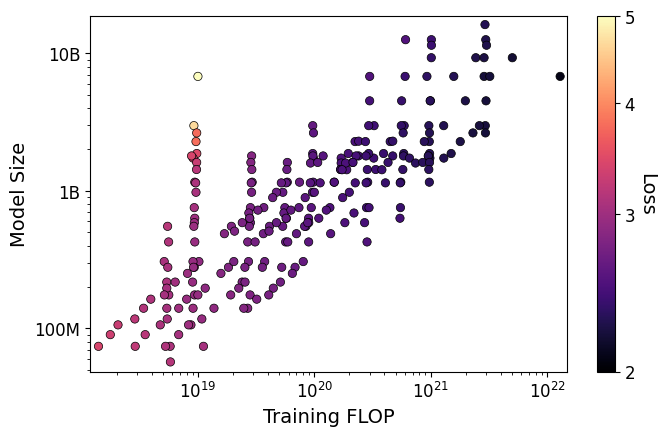

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

# Adjusting default font sizes for better readability
plt.rcParams.update({"font.size": 12, "axes.labelsize": 14, "axes.titlesize": 16})

# Creating the scatter plot
plt.figure(figsize=(10 / 1.3, 6 / 1.3))
sc = plt.scatter(
    training_df["Training FLOP"],
    training_df["Model Size"],
    c=training_df["loss"],
    cmap="magma",
    norm=LogNorm(vmin=2.0, vmax=5.0),
    marker="o",
    edgecolors="black",
    linewidths=0.5,
)

# Adding a color bar
cbar = plt.colorbar(sc)
cbar.set_label("Loss", rotation=270, labelpad=15)

# Directly setting color bar tick labels to avoid scientific notation
cbar_ticks = [2, 3, 4, 5]  # Define the ticks you want based on your data range
cbar.set_ticks(cbar_ticks)  # Set these ticks on the color bar
cbar.set_ticklabels(
    [str(tick) for tick in cbar_ticks]
)  # Set the tick labels as plain strings of these ticks

# Setting the plot labels and title
plt.xlabel("Training FLOP")
plt.ylabel("Model Size")

# Applying log scale to both axes
plt.xscale("log")
plt.yscale("log")


# Custom formatter function for y-axis
def custom_formatter(x, pos):
    if x >= 1e9:
        return "{:d}B".format(int(x / 1e9))
    elif x >= 1e6:
        return "{:d}M".format(int(x / 1e6))
    elif x >= 1e3:
        return "{:d}K".format(int(x / 1e3))
    else:
        return str(int(x))


# Applying the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))

# Custom formatter for axes to display ticks as 10^x
plt.gca().xaxis.set_major_formatter(
    ticker.LogFormatterSciNotation(base=10, labelOnlyBase=False)
)

# Setting axes limits
plt.xlim(
    [min(training_df["Training FLOP"]) * 0.85, max(training_df["Training FLOP"]) * 1.15]
)
plt.ylim([min(training_df["Model Size"]) * 0.85, max(training_df["Model Size"]) * 1.15])

# Saving the plot to a PDF
plt.savefig("training_flop_vs_model_size.pdf")

plt.show()

In [12]:
# Custom formatter function for y-axis
def custom_formatter(x, pos):
    if x >= 1e9:
        return "{:d}B".format(int(x / 1e9))
    elif x >= 1e6:
        return "{:d}M".format(int(x / 1e6))
    elif x >= 1e3:
        return "{:d}K".format(int(x / 1e3))
    else:
        return str(int(x))

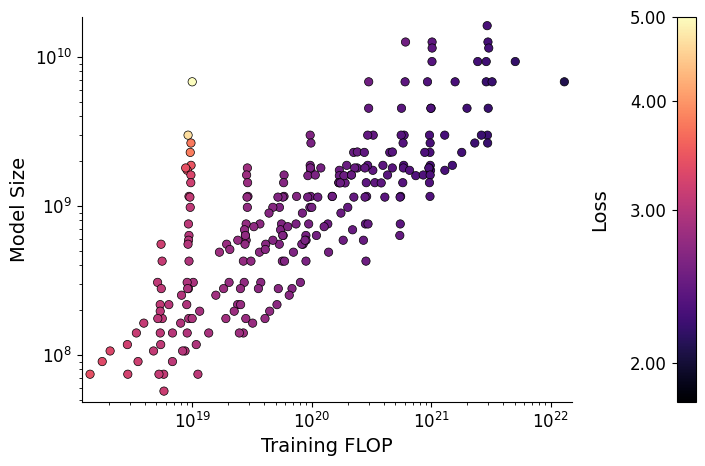

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
from matplotlib.transforms import Bbox

# Adjusting default font sizes for better readability
plt.rcParams.update({"font.size": 12, "axes.labelsize": 14, "axes.titlesize": 16})

# Creating the scatter plot
fig, ax = plt.subplots(figsize=(12 / 1.2, 6 / 1.2))
sc = ax.scatter(
    training_df["Training FLOP"],
    training_df["Model Size"],
    c=training_df["loss"],
    cmap="magma",
    norm=LogNorm(vmin=1.804501, vmax=5.0),
    marker="o",
    edgecolors="black",
    linewidths=0.5,
)

# Adding a color bar on the right, but with ticks and text to the left of the bar
cbar = fig.colorbar(sc, ax=ax, location="right", pad=0.15)
cbar.set_label("Loss", rotation=90, labelpad=15)
cbar.ax.yaxis.set_ticks_position("left")
cbar.ax.yaxis.set_label_position("left")

# Adjusting subplot parameters to remove whitespace
fig.subplots_adjust(left=0.1, right=0.8)  # Adjust the right margin here

# Removing the top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Directly setting color bar tick labels to avoid scientific notation
cbar_ticks = [2.00, 3.00, 4.00, 5.00]
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])

# Setting the plot labels and title
ax.set_xlabel("Training FLOP")
ax.set_ylabel("Model Size")

# Applying log scale to both axes
ax.set_xscale("log")
ax.set_yscale("log")

# Custom formatter for axes
ax.xaxis.set_major_formatter(
    ticker.LogFormatterSciNotation(base=10, labelOnlyBase=False)
)

# Setting axes limits
ax.set_xlim(
    [min(training_df["Training FLOP"]) * 0.85, max(training_df["Training FLOP"]) * 1.15]
)
ax.set_ylim(
    [min(training_df["Model Size"]) * 0.85, max(training_df["Model Size"]) * 1.15]
)

# Saving the plot to a PDF
# Get the current bounding box of the figure
fig_bbox = fig.get_tightbbox(fig.canvas.get_renderer())

# Create a new bounding box by modifying the original
# Increase left and right margins by specifying a shift
padding = 0.85  # Change the padding value as needed (in inches)
new_fig_bbox = Bbox.from_extents(
    fig_bbox.x0 - padding,  # Extend left by padding inches
    fig_bbox.y0,  # Keep bottom the same
    fig_bbox.x1 + padding + 0.25,  # Extend right by padding inches
    fig_bbox.y1,  # Keep top the same
)

# Save the figure using the new bounding box
plt.savefig("training_flop_vs_model_size.pdf", bbox_inches=new_fig_bbox)

plt.show()

In [14]:
# outlier datapoints
training_df["d_n_ratio"] = training_df["Training Tokens"] / training_df["Model Size"]

In [15]:
training_df

,Model Size,Training Tokens,Training FLOP,loss,rounded_ms,d_model,ffw_size,kv_size,n_heads,n_layers,...,Reported Parameters (M),"Tied (Un)Embed, No Gating","Untied (Un)Embed, No Gating","Untied (Un)Embed, Gating","Untied (Un)Embed, Gating, Shared KV","Tied (Un)Embed, No Gating, Incorrect Attn Params Prefactor",Signed Relative Error Correct to Reported (%),Signed Relative Error Incorrect to Reported (%),old_ms,d_n_ratio
0,6.795000e+09,2.451060e+08,9.993853e+18,5.005582,6796,3584,14336,128,28,40,...,6796,6281,6396,8451,7937.613824,6795,7.58,0.02,6.795600e+09,0.036072
1,2.979000e+09,5.161647e+08,9.227541e+18,4.665232,2980,2560,10240,128,20,34,...,2980,2756,2839,3730,3507.036160,2979,7.51,0.03,2.979521e+09,0.173268
2,2.638000e+09,6.160421e+08,9.753047e+18,3.765563,2639,2560,10240,128,20,30,...,2639,2442,2524,3310,3113.820160,2638,7.48,0.03,2.638631e+09,0.233526
3,2.282000e+09,7.025502e+08,9.622708e+18,3.793872,2283,2304,9216,128,18,32,...,2283,2113,2187,2866,2696.269824,2282,7.47,0.03,2.282804e+09,0.307866
4,1.868000e+09,8.116029e+08,9.771731e+18,3.446995,2007,2304,9216,128,18,26,...,2007,1730,1804,2357,2218.512384,1868,13.78,6.91,2.006673e+09,0.434477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,1.730000e+09,1.248775e+11,1.296639e+21,2.286446,1731,2304,9216,128,18,24,...,1731,1603,1677,2187,2059.259904,1730,7.40,0.04,1.730547e+09,72.183540
241,2.282000e+09,1.310546e+11,1.795036e+21,2.249076,2283,2304,9216,128,18,32,...,2283,2113,2187,2866,2696.269824,2282,7.47,0.03,2.282809e+09,57.429720
242,2.638000e+09,1.457902e+11,2.308123e+21,2.222281,2639,2560,10240,128,20,30,...,2639,2442,2524,3310,3113.820160,2638,7.48,0.03,2.638636e+09,55.265415
243,2.979000e+09,1.466122e+11,2.621011e+21,2.212313,2980,2560,10240,128,20,34,...,2980,2756,2839,3730,3507.036160,2979,7.51,0.03,2.979528e+09,49.215242


# Replicate methodology from Chinchilla paper



Define things

In [16]:
nr_of_models_excluded = 5

In [17]:
N = training_df["Model Size"].values
D = training_df["Training Tokens"].values
losses = training_df["loss"].values
bootstraps = 4000

sorted_losses = sorted(losses)
if nr_of_models_excluded == 0:
    indices = list(range(len(N)))
else:
    sorted_losses = sorted(losses)
    indices = [
        i for i in range(len(N)) if losses[i] < sorted_losses[-nr_of_models_excluded]
    ]

np.random.seed(42)
random_indices = [
    np.random.choice(indices, size=len(indices), replace=True)
    for _ in range(bootstraps)
]

In [18]:
# import autograd.numpy as np
# from autograd.scipy.stats import norm
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.special import erf

# true_params = np.array([np.log(406.4), np.log(410.7), np.log(1.69), 0.34, 0.28])
true_params = np.array([6.0073404, 6.0179186, 0.5267228, 0.33917084, 0.2849083])
true_params_rounded = np.array([np.log(406.4), np.log(410.7), np.log(1.69), 0.34, 0.28])


# Define the log-sum-exp function
def log_sum_exp(a, b, e, alpha, beta, N, D):
    return np.log(
        np.exp(a - alpha * np.log(N)) + np.exp(b - beta * np.log(D)) + np.exp(e)
    )


# Define the Huber loss function
def custom_huber_loss(y_true, y_pred, delta=1e-3):
    # Calculate the difference
    diff = y_true - y_pred
    # Calculate the condition for Huber loss
    cond = np.abs(diff) <= delta
    # Apply Huber loss formula
    loss = np.where(cond, 0.5 * diff**2, delta * (np.abs(diff) - 0.5 * delta))
    return np.sum(loss)


def huber_normalizing_factor(delta=1e-3):
    return (
        np.sqrt(2 * np.pi) * (1 - 2 * norm.sf(delta))
        + 2 * np.exp(-0.5 * delta**2) / delta
    )


def huber_logpdf(x, delta=1e-3, loc=0, scale=1):
    x = (x - loc) / scale

    cond = np.abs(x) <= delta
    loss = np.where(cond, 0.5 * x**2, delta * (np.abs(x) - 0.5 * delta))
    return -loss - np.log(huber_normalizing_factor(delta=delta)) - np.log(scale)


def huber_pdf(x, delta=1e-3, loc=0, scale=1):
    return np.exp(huber_logpdf(x, delta=delta, loc=loc, scale=scale))


# Define the objective function to be minimized
def objective(params, N, D, losses):
    a, b, e, alpha, beta, sigma = params
    predictions = log_sum_exp(a, b, e, alpha, beta, N, D)
    return -np.sum(
        huber_logpdf(np.log(losses), loc=predictions, scale=np.exp(sigma), delta=1e-3)
    )
    # return custom_huber_loss(np.log(losses), predictions, delta=1e-3)


def scale_objective(sigma, params, N, D, losses):
    a, b, e, alpha, beta = params
    predictions = log_sum_exp(a, b, e, alpha, beta, N, D)
    return -np.sum(
        huber_logpdf(np.log(losses), loc=predictions, scale=np.exp(sigma), delta=1e-3)
    )
    # return custom_huber_loss(np.log(losses), predictions, delta=1e-3)


def constant_term_objective(params, a, b, alpha, beta, N, D, losses):
    e, sigma = params
    predictions = log_sum_exp(a, b, e, alpha, beta, N, D)
    return -np.sum(
        huber_logpdf(np.log(losses), loc=predictions, scale=np.exp(sigma), delta=1e-3)
    )


def huber_loss_objective(params, N, D, losses):
    a, b, e, alpha, beta = params
    predictions = log_sum_exp(a, b, e, alpha, beta, N, D)
    return custom_huber_loss(np.log(losses), predictions, delta=1e-3)


# Define the parameter untransform
def untransform_params(param_array):
    if len(np.shape(param_array)) == 2:
        return np.hstack((np.exp(param_array[:, :3]), param_array[:, 3:]))
    else:
        return np.hstack((np.exp(param_array[:3]), param_array[3:]))


# Define the Huber loss function on residuals
def huber_loss(residuals, delta=1e-3):
    # Calculate the difference
    diff = residuals
    # Calculate the condition for Huber loss
    cond = np.abs(diff) <= delta
    # Apply Huber loss formula
    loss = np.where(cond, 0.5 * diff**2, delta * (np.abs(diff) - 0.5 * delta))
    return loss

### Replicate exactly

In [19]:
# import autograd.numpy as np
import numpy as np
from scipy.optimize import minimize

N = training_df["Model Size"].values
D = training_df["Training Tokens"].values
losses = training_df["loss"].values

# Set up the grid for initial parameter values
alpha_vals = np.arange(0, 2.5, 0.5)
beta_vals = np.arange(0, 2.5, 0.5)
e_vals = np.arange(-1, 1.5, 0.5)
a_vals = np.arange(0, 30, 5)
b_vals = np.arange(0, 30, 5)

# Perform the optimization using L-BFGS over the grid of initial values
best_loss = np.inf
best_params = None

from itertools import product

results_dict = {}
for alpha, beta, e, a, b in product(alpha_vals, beta_vals, e_vals, a_vals, b_vals):
    init_params = [a, b, e, alpha, beta]
    result = minimize(
        huber_loss_objective,
        init_params,
        args=(N[indices], D[indices], losses[indices]),
        method="L-BFGS-B",
    )
    results_dict[tuple(init_params)] = {"params": result.x, "loss": result.fun}
    if result.success and result.fun < best_loss:
        best_loss = result.fun
        best_params = result.x
        print(f"New best loss: {best_loss}")
        print(f"Best params: {best_params}")
        print(f"Initial guess: {init_params}")

# Transform the fitted parameters a, b, e to A, B, E
if best_params is not None:
    A = np.exp(best_params[0])
    B = np.exp(best_params[1])
    E = np.exp(best_params[2])
    alpha = best_params[3]
    beta = best_params[4]
    print(f"Best fit parameters: A={A}, B={B}, E={E}, alpha={alpha}, beta={beta}")
else:
    print("Optimization failed to converge.")

New best loss: 0.0011177272996366133
Best params: [6.82942743 6.58650132 0.58160312 0.38575218 0.31348479]
Initial guess: [0, 0, -1.0, 0.0, 0.0]
New best loss: 0.0010349746072268184
Best params: [6.1736323  7.50539616 0.59091073 0.34741974 0.35908157]
Initial guess: [0, 15, -1.0, 0.0, 0.0]
New best loss: 0.0010349744464343597
Best params: [6.17386865 7.5060035  0.59093943 0.34743295 0.35911196]
Initial guess: [0, 25, -1.0, 0.0, 0.0]
New best loss: 0.0010349744277525301
Best params: [6.17412967 7.5060832  0.59094855 0.34744756 0.35911582]
Initial guess: [10, 25, 1.0, 0.0, 0.0]
New best loss: 0.0010349744076168913
Best params: [6.17479428 7.50673122 0.59099825 0.34748659 0.35914811]
Initial guess: [20, 15, 0.5, 0.0, 1.0]
New best loss: 0.0010349744075600431
Best params: [6.17434011 7.50635631 0.59096292 0.34745916 0.35912927]
Initial guess: [10, 0, 0.5, 0.5, 0.0]
New best loss: 0.0010349743969809112
Best params: [6.17466738 7.50642911 0.59098239 0.34747851 0.35913314]
Initial guess: [20,

# Chinchilla parametric fit fits the data poorly

### Our estimates

In [20]:
import autograd.numpy as np

# Set up the grid for initial parameter values
param_list = []

for num, indices in enumerate(random_indices):
    # Perform the optimization using BFGS
    best_loss = np.inf
    best_params = None

    init_params = list(true_params)
    result = minimize(
        huber_loss_objective,
        init_params,
        args=(N[indices], D[indices], losses[indices]),
        jac=grad(huber_loss_objective),
        method="BFGS",
    )

    best_loss = result.fun
    best_params = result.x
    # print(f"New best loss: {best_loss}")
    # print(f"Best params: {best_params}")

    if num % 100 == 99:
        print("Bootstrap step %d completed" % (num + 1))

    param_list.append(result.x)

param_list = np.array(param_list)
cov_matrix = np.cov(np.transpose(param_list))

Bootstrap step 100 completed
Bootstrap step 200 completed
Bootstrap step 300 completed
Bootstrap step 400 completed
Bootstrap step 500 completed
Bootstrap step 600 completed
Bootstrap step 700 completed
Bootstrap step 800 completed
Bootstrap step 900 completed
Bootstrap step 1000 completed
Bootstrap step 1100 completed
Bootstrap step 1200 completed
Bootstrap step 1300 completed
Bootstrap step 1400 completed
Bootstrap step 1500 completed
Bootstrap step 1600 completed
Bootstrap step 1700 completed
Bootstrap step 1800 completed
Bootstrap step 1900 completed
Bootstrap step 2000 completed
Bootstrap step 2100 completed
Bootstrap step 2200 completed
Bootstrap step 2300 completed
Bootstrap step 2400 completed
Bootstrap step 2500 completed
Bootstrap step 2600 completed
Bootstrap step 2700 completed
Bootstrap step 2800 completed
Bootstrap step 2900 completed
Bootstrap step 3000 completed
Bootstrap step 3100 completed
Bootstrap step 3200 completed
Bootstrap step 3300 completed
Bootstrap step 3400

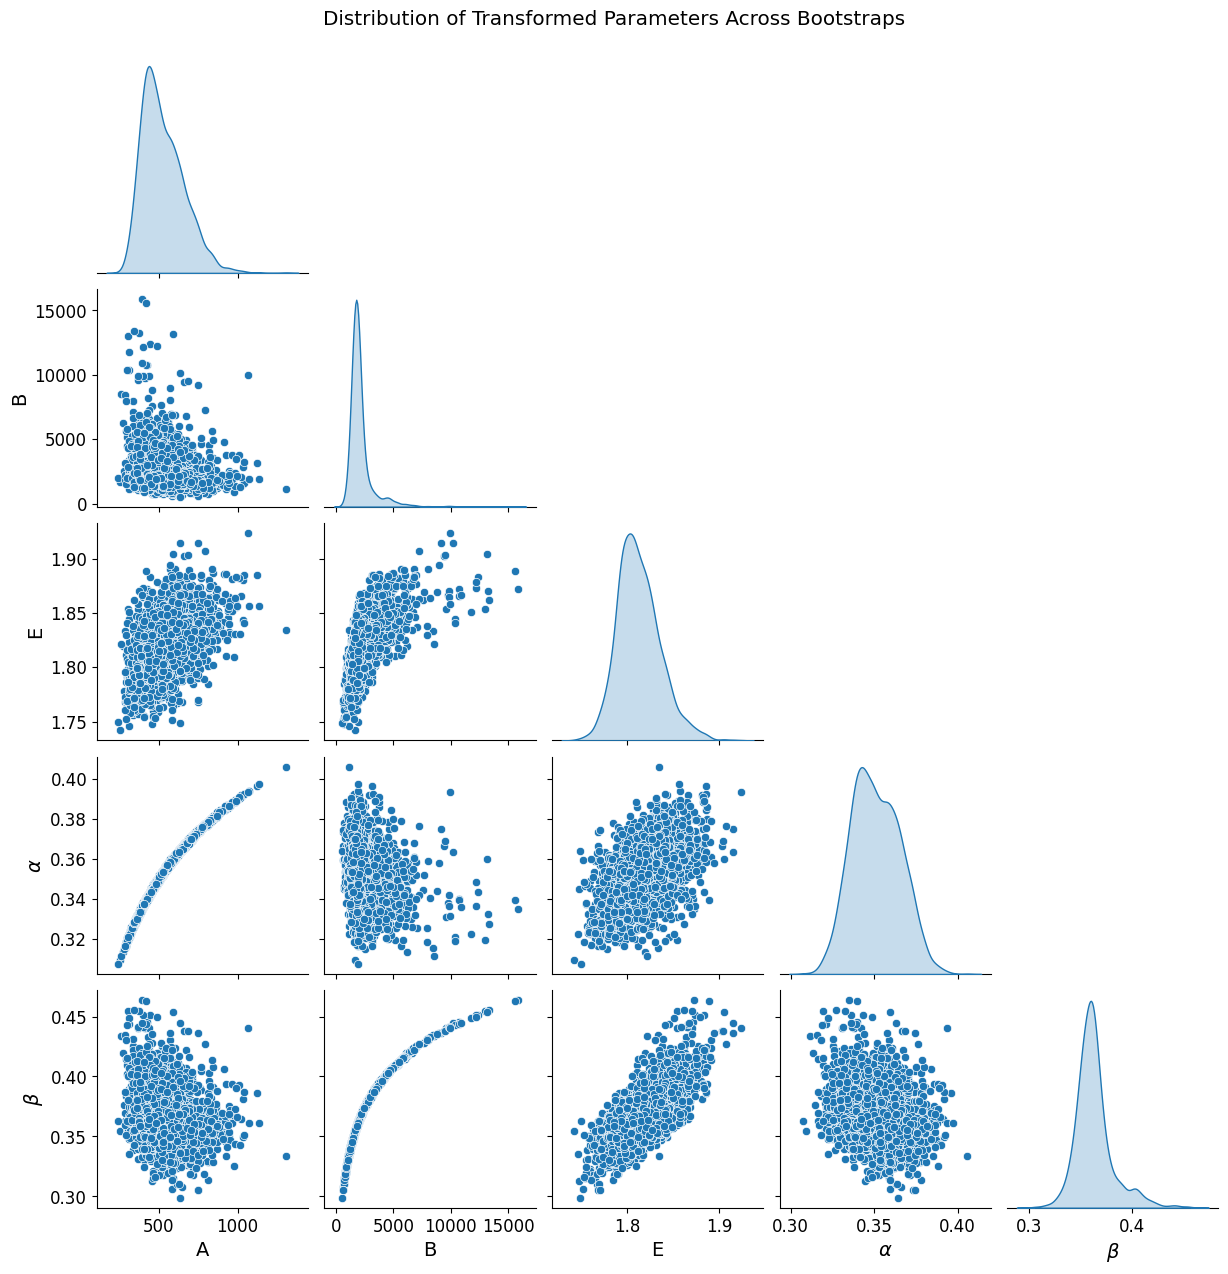

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Applying the given transformations
transformed_params = np.exp(
    param_list[:, :3]
)  # Apply exp() to the first three parameters
alpha_beta = param_list[:, 3:]  # The last two parameters remain unchanged
transformed_params = np.hstack(
    [transformed_params, alpha_beta]
)  # Combine the transformed and untransformed parameters

# Creating a DataFrame for the transformed parameters
transformed_params_df = pd.DataFrame(
    transformed_params, columns=["A", "B", "E", r"$\alpha$", r"$\beta$"]
)

# Plotting the distribution of each transformed parameter across bootstraps
sns.pairplot(transformed_params_df, diag_kind="kde", corner=True)
plt.suptitle("Distribution of Transformed Parameters Across Bootstraps", y=1.02)
plt.show()

In [22]:
param_list = np.array(param_list)
cov_matrix = np.cov(np.transpose(param_list))

param_list_untransformed = untransform_params(param_list)
cov_matrix_untransformed = np.cov(np.transpose(param_list_untransformed))

In [23]:
import autograd.numpy as np

init_params = list(true_params) + [0]

indices = (
    list(range(len(N)))
    if nr_of_models_excluded == 0
    else [
        i for i in range(len(N)) if losses[i] < sorted(losses)[-nr_of_models_excluded]
    ]
)

result = minimize(
    objective,
    init_params,
    args=(N[indices], D[indices], losses[indices]),
    method="BFGS",
    jac=grad(objective),
)

print(result)
print(result.x)

estimated_params = result.x[:5]
estimated_params_untransformed = untransform_params(estimated_params)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -876.2734428369745
        x: [ 6.080e+00  7.498e+00  5.864e-01  3.419e-01  3.587e-01
            -1.225e+01]
      nit: 124
      jac: [-1.801e-02 -2.054e-02 -8.433e-02  3.717e-01  4.653e-01
            -7.577e-06]
 hess_inv: [[ 1.802e-06  5.328e-07 ...  2.577e-08  7.094e-07]
            [ 5.328e-07  1.847e-06 ...  9.214e-08 -7.440e-07]
            ...
            [ 2.577e-08  9.214e-08 ...  4.599e-09 -3.828e-08]
            [ 7.094e-07 -7.440e-07 ... -3.828e-08  4.056e-03]]
     nfev: 379
     njev: 367
[  6.08027084   7.49775177   0.58637926   0.34186178   0.3586894
 -12.25204184]


In [24]:
standard_errors = np.sqrt(np.diag(cov_matrix[:5, :5]))
standard_errors_untransformed = np.sqrt(np.diag(cov_matrix_untransformed[:5, :5]))

parameter_labels = ["A", "B", "E", "alpha", "beta"]
print(
    f"Corrected (Epoch) Parameter estimates and their standard errors using {column}\n"
)
for index, label in enumerate(parameter_labels):
    print(
        "%s: %.5f (%.5f)"
        % (
            label,
            estimated_params_untransformed[index],
            standard_errors_untransformed[index],
        )
    )

Corrected (Epoch) Parameter estimates and their standard errors using Tied (Un)Embed, No Gating, Incorrect Attn Params Prefactor

A: 437.14758 (132.96707)
B: 1803.98209 (1209.98724)
E: 1.79747 (0.02324)
alpha: 0.34186 (0.01446)
beta: 0.35869 (0.01861)


In [25]:
# Calculating 95% Confidence Intervals for each parameter
confidence_intervals = {}

# For each column in the DataFrame, calculate the 2.5th and 97.5th percentiles
for column in transformed_params_df.columns:
    lower_bound = np.percentile(transformed_params_df[column], 2.5)
    upper_bound = np.percentile(transformed_params_df[column], 97.5)
    confidence_intervals[column] = (lower_bound, upper_bound)

# Printing out the 95% Confidence Intervals for each parameter
print("95% Confidence Intervals for Parameter Estimates\n")
for parameter, (lower, upper) in confidence_intervals.items():
    print(f"{parameter}: ({lower:.3f}, {upper:.3f})")

95% Confidence Intervals for Parameter Estimates

A: (332.779, 828.046)
B: (1079.027, 5374.510)
E: (1.773, 1.866)
$\alpha$: (0.325, 0.379)
$\beta$: (0.333, 0.411)


In [26]:
true_params_unlogged = np.array(
    [np.exp(6.0073404), np.exp(6.0179186), np.exp(0.5267228), 0.33917084, 0.2849083]
)
true_params_rounded_unlogged = np.array([406.4, 410.7, 1.69, 0.34, 0.28])

In [27]:
from scipy.stats import t
import numpy as np

# Calculate t-statistics
t_statistics = (
    estimated_params_untransformed - true_params_unlogged
) / standard_errors_untransformed

# Degrees of freedom
degrees_of_freedom = len(indices) - 5

# Calculate two-tailed p-values
p_values = (
    t.sf(np.abs(t_statistics), degrees_of_freedom) * 2
)  # times 2 for two-tailed test

# Print parameter names alongside p-values
for label, p_value in zip(parameter_labels, p_values):
    print(f"{label}: P-value = {p_value:.1e}")

A: P-value = 8.2e-01
B: P-value = 2.5e-01
E: P-value = 1.2e-05
alpha: P-value = 8.5e-01
beta: P-value = 9.8e-05


### Chi squared test

In [28]:
transformed_params_df

,A,B,E,$\alpha$,$\beta$
0,407.931555,1984.378916,1.795353,0.337666,0.363480
1,472.132460,1392.240614,1.792559,0.346895,0.345866
2,791.804482,1942.965513,1.847293,0.377066,0.362278
3,368.734830,1883.095869,1.786230,0.331951,0.360869
4,366.284041,1959.441288,1.788156,0.331649,0.362604
...,...,...,...,...,...
3995,359.091258,2407.623010,1.799683,0.330054,0.373354
3996,407.586256,1222.518910,1.771416,0.337581,0.339966
3997,524.727350,1390.518391,1.802690,0.353553,0.345756
3998,704.453515,1698.399414,1.826723,0.369601,0.355682


Chi squared for equality of all parameters

In [29]:
best_params

array([5.94149015, 7.49869075, 0.57973931, 0.33336054, 0.35896217])

In [30]:
# baseline_fitted_params = [  6.17795598,   7.64273236,   0.59711196,   0.34781303,   0.36585412  ]

baseline_fitted_params = [6.17795598, 7.64273236, 0.59711196, 0.34781303, 0.36585412]

# fitted_params_with_outliers = [6.13834459, 9.43584213, 0.63412782, 0.3453568 , 0.45189211]

In [31]:
from scipy.stats import chi2
import numpy as np


def chi_squared_stat(params_1, params_2, cov_matrix):
    return (
        np.transpose(params_1 - params_2)
        @ np.linalg.inv(cov_matrix)
        @ (params_1 - params_2)
    )


print(
    "Difference between Hoffmann et al. (2022) params and our params:",
    true_params - baseline_fitted_params,
)
chi_squared = chi_squared_stat(true_params, estimated_params, cov_matrix[:5, :5])

print("Implied chi^2 (df=5) test statistic: %.2f" % (chi_squared))
print("Implied chi^2 (df=5) p-value: %.2e\n" % (chi2.sf(chi_squared, df=5)))

print(
    "Difference between our default (excluding five outliers) params and our params without any outlier exclusion:",
    baseline_fitted_params - estimated_params,
)
chi_squared = chi_squared_stat(
    baseline_fitted_params, estimated_params, cov_matrix[:5, :5]
)

print("Implied chi^2 (df=5) test statistic: %.2f" % (chi_squared))
print("Implied chi^2 (df=5) p-value: %.2e" % (chi2.sf(chi_squared, df=5)))

Difference between Hoffmann et al. (2022) params and our params: [-0.17061558 -1.62481376 -0.07038916 -0.00864219 -0.08094582]
Implied chi^2 (df=5) test statistic: 258.01
Implied chi^2 (df=5) p-value: 1.05e-53

Difference between our default (excluding five outliers) params and our params without any outlier exclusion: [0.09768514 0.14498059 0.0107327  0.00595125 0.00716472]
Implied chi^2 (df=5) test statistic: 2.32
Implied chi^2 (df=5) p-value: 8.03e-01


# Our fit is better

## Plots

In [32]:
import matplotlib.pyplot as plt
import numpy as np


def scaling_law(N, D, params):
    logA, logB, logE, alpha, beta = params
    A, B, E = np.exp([logA, logB, logE])
    return E + A / N**alpha + B / D**beta


# Your residuals calculation
A, B, E, alpha, beta = true_params_unlogged
residuals = losses[indices] - scaling_law(
    N[indices], D[indices], true_params_rounded
)  # Hoffmann estimates
mse = np.mean(residuals**2)

residuals_ours = losses[indices] - np.exp(
    log_sum_exp(*estimated_params, N[indices], D[indices])
)
mse_ours = np.mean(residuals_ours**2)

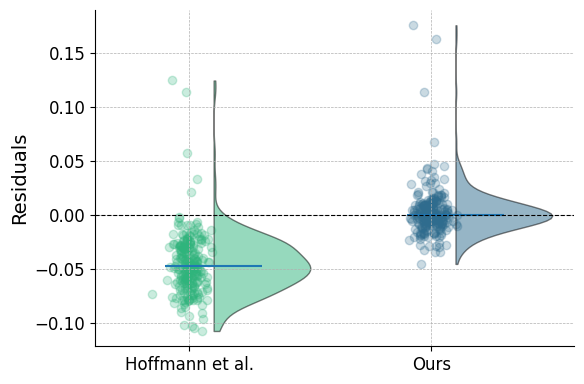

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

# Assuming residuals_2 and residuals_2_ours are numpy arrays with your data
# Define the data

color_ours = 0.35
color_chinchilla = 0.65

data_control = (
    residuals  # replace with your actual data for population-matched controls
)
data_active = residuals_ours  # replace with your actual data for musically active cases

# Create a new figure
fig, ax = plt.subplots(figsize=(6, 4))

# Check for the largest residual and set the y-limit if necessary
largest_residual = max(np.max(data_control), np.max(data_active))
if largest_residual > 0.6:
    ax.set_ylim(-0.15, 0.2)

# Scatter plots with a small random noise to x-values for jitter effect
scatter_control = np.random.normal(1, 0.04, size=len(data_control))
scatter_active = np.random.normal(2, 0.04, size=len(data_active))
ax.scatter(
    scatter_control, data_control, alpha=0.25, color=plt.cm.viridis(color_chinchilla)
)
ax.scatter(scatter_active, data_active, alpha=0.25, color=plt.cm.viridis(color_ours))

# Offset for the violin plots to be right of the scatter points
violin_offset = 0.1  # Adjust as needed

# Create violin plots on the same axis as scatter plots, slightly offset to the right
violin_parts = ax.violinplot(
    [data_control, data_active],
    positions=[1 + violin_offset, 2 + violin_offset],
    widths=0.8,
    showmeans=False,
    showextrema=False,
    showmedians=True,
)

# Make the violin plot one-sided by adjusting its paths
colors = [
    plt.cm.viridis(color_chinchilla),
    plt.cm.viridis(color_ours),
]  # Use the same colors as scatter plots
for pc, color in zip(violin_parts["bodies"], colors):
    pc.set_facecolor(color)
    pc.set_edgecolor("black")
    pc.set_alpha(0.5)
    m = np.mean(pc.get_paths()[0].vertices[:, 0])  # Find the center of the violin
    pc.get_paths()[0].vertices[:, 0] = np.clip(
        pc.get_paths()[0].vertices[:, 0], m, np.inf
    )  # Clip to the right

# Calculate means and confidence intervals for both groups
mean_control = np.mean(data_control)
mean_active = np.mean(data_active)
ci_control = np.std(data_control) * 1.96 / np.sqrt(len(data_control))
ci_active = np.std(data_active) * 1.96 / np.sqrt(len(data_active))

# Set the x-tick labels
ax.set_xticks([1, 2])
ax.set_xticklabels(["Hoffmann et al.", "Ours"])

# Set y-label
ax.set_ylabel("Residuals")

# Add grid to the plot
ax.grid(True, which="both", axis="both", linestyle="--", linewidth=0.5)

# Remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add a horizontal line at y=0
ax.axhline(y=0, color="black", linestyle="--", linewidth=0.8)

# Set layout to be tight
plt.tight_layout()

plt.savefig("distributions_1.pdf")
# plt.savefig("distributions2.pdf")

# Show plot
plt.show()

In [34]:
import matplotlib.pyplot as plt
import numpy as np


def scaling_law(N, D, params):
    logA, logB, logE, alpha, beta = params
    A, B, E = np.exp([logA, logB, logE])
    return E + A / N**alpha + B / D**beta


# Your residuals calculation
A, B, E, alpha, beta = true_params_unlogged
residuals = losses[indices] - scaling_law(
    N[indices], D[indices], true_params
)  # Hoffmann estimates
mse = np.mean(residuals**2)

residuals_ours = losses[indices] - np.exp(
    log_sum_exp(*estimated_params, N[indices], D[indices])
)
mse_ours = np.mean(residuals_ours**2)

from scipy import stats

t_statistic, p_value = stats.ttest_ind(residuals, residuals_ours, equal_var=True)

print(f"T-statistic: {t_statistic}, P-value: {p_value}")

T-statistic: 2.080845727994173, P-value: 0.03797989314041032


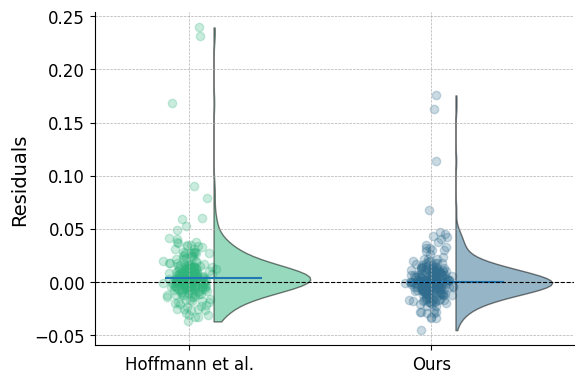

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

# Assuming residuals_2 and residuals_2_ours are numpy arrays with your data
# Define the data

color_ours = 0.35
color_chinchilla = 0.65

data_control = (
    residuals  # replace with your actual data for population-matched controls
)
data_active = residuals_ours  # replace with your actual data for musically active cases

# Create a new figure
fig, ax = plt.subplots(figsize=(6, 4))

# Check for the largest residual and set the y-limit if necessary
largest_residual = max(np.max(data_control), np.max(data_active))
if largest_residual > 0.6:
    ax.set_ylim(-0.15, 0.2)

# Scatter plots with a small random noise to x-values for jitter effect
scatter_control = np.random.normal(1, 0.04, size=len(data_control))
scatter_active = np.random.normal(2, 0.04, size=len(data_active))
ax.scatter(
    scatter_control, data_control, alpha=0.25, color=plt.cm.viridis(color_chinchilla)
)
ax.scatter(scatter_active, data_active, alpha=0.25, color=plt.cm.viridis(color_ours))

# Offset for the violin plots to be right of the scatter points
violin_offset = 0.1  # Adjust as needed

# Create violin plots on the same axis as scatter plots, slightly offset to the right
violin_parts = ax.violinplot(
    [data_control, data_active],
    positions=[1 + violin_offset, 2 + violin_offset],
    widths=0.8,
    showmeans=False,
    showextrema=False,
    showmedians=True,
)

# Make the violin plot one-sided by adjusting its paths
colors = [
    plt.cm.viridis(color_chinchilla),
    plt.cm.viridis(color_ours),
]  # Use the same colors as scatter plots
for pc, color in zip(violin_parts["bodies"], colors):
    pc.set_facecolor(color)
    pc.set_edgecolor("black")
    pc.set_alpha(0.5)
    m = np.mean(pc.get_paths()[0].vertices[:, 0])  # Find the center of the violin
    pc.get_paths()[0].vertices[:, 0] = np.clip(
        pc.get_paths()[0].vertices[:, 0], m, np.inf
    )  # Clip to the right

# Calculate means and confidence intervals for both groups
mean_control = np.mean(data_control)
mean_active = np.mean(data_active)
ci_control = np.std(data_control) * 1.96 / np.sqrt(len(data_control))
ci_active = np.std(data_active) * 1.96 / np.sqrt(len(data_active))

# Set the x-tick labels
ax.set_xticks([1, 2])
ax.set_xticklabels(["Hoffmann et al.", "Ours"])

# Set y-label
ax.set_ylabel("Residuals")

# Add grid to the plot
ax.grid(True, which="both", axis="both", linestyle="--", linewidth=0.5)

# Remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add a horizontal line at y=0
ax.axhline(y=0, color="black", linestyle="--", linewidth=0.8)

# Set layout to be tight
plt.tight_layout()

plt.savefig("distributions_2.pdf")
# plt.savefig("distributions2.pdf")

# Show plot
plt.show()

## Tests

## Likelihood test

In [36]:
# Define the objective function to be minimized
def objective(params, N, D, losses):
    a, b, e, alpha, beta, sigma = params
    predictions = log_sum_exp(a, b, e, alpha, beta, N, D)
    return -np.sum(
        huber_logpdf(np.log(losses), loc=predictions, scale=np.exp(sigma), delta=1e-3)
    )
    # return custom_huber_loss(np.log(losses), predictions, delta=1e-3)


def scale_objective(sigma, params, N, D, losses):
    a, b, e, alpha, beta = params
    predictions = log_sum_exp(a, b, e, alpha, beta, N, D)
    return -np.sum(
        huber_logpdf(np.log(losses), loc=predictions, scale=np.exp(sigma), delta=1e-3)
    )
    # return custom_huber_loss(np.log(losses), predictions, delta=1e-3)


def constant_term_objective(params, a, b, alpha, beta, N, D, losses):
    e, sigma = params
    predictions = log_sum_exp(a, b, e, alpha, beta, N, D)
    return -np.sum(
        huber_logpdf(np.log(losses), loc=predictions, scale=np.exp(sigma), delta=1e-3)
    )


def huber_loss_objective(params, N, D, losses):
    a, b, e, alpha, beta = params
    predictions = log_sum_exp(a, b, e, alpha, beta, N, D)
    return custom_huber_loss(np.log(losses), predictions, delta=1e-3)

In [37]:
import autograd.numpy as np

param_list = np.array(param_list)
cov_matrix = np.cov(np.transpose(param_list))

param_list_untransformed = untransform_params(param_list)
cov_matrix_untransformed = np.cov(np.transpose(param_list_untransformed))

init_params = list(true_params) + [0]
indices = [i for i in range(len(N)) if losses[i] < sorted(losses)[-5]]

# estimate parameters
result = minimize(
    objective,
    init_params,
    args=(N[indices], D[indices], losses[indices]),
    method="BFGS",
    jac=grad(objective),
    tol=1e-1,
)

estimated_params = result.x[:5]
estimated_params_untransformed = untransform_params(estimated_params)

indices_with_outliers = [i for i in range(len(N))]

# fit scale param for estimated (without outliers)
result = minimize(
    scale_objective,
    init_params[-1],
    args=(estimated_params, N[indices], D[indices], losses[indices]),
    method="BFGS",
    jac=grad(scale_objective),
    tol=1e-1,
)
estimated_params_scale_adjusted_no_outliers = list(estimated_params) + [result.x[0]]

# fit scale param for estimated (with outliers)
result = minimize(
    scale_objective,
    init_params[-1],
    args=(
        estimated_params,
        N[indices_with_outliers],
        D[indices_with_outliers],
        losses[indices_with_outliers],
    ),
    method="BFGS",
    jac=grad(scale_objective),
    tol=1e-1,
)
estimated_params_scale_adjusted_with_outliers = list(estimated_params) + [result.x[0]]

In [38]:
# fit scale param for rounded Chinchilla parameters (without outliers)
result = minimize(
    scale_objective,
    init_params[-1],
    args=(true_params_rounded, N[indices], D[indices], losses[indices]),
    method="BFGS",
    jac=grad(scale_objective),
    tol=1e-9,
)

rounded_chinchilla_params_with_scale_no_outliers = list(true_params_rounded) + [
    result.x[0]
]


# fit scale param for rounded Chinchilla parameters (with outliers)
result = minimize(
    scale_objective,
    init_params[-1],
    args=(
        true_params_rounded,
        N[indices_with_outliers],
        D[indices_with_outliers],
        losses[indices_with_outliers],
    ),
    method="BFGS",
    jac=grad(scale_objective),
    tol=1e-9,
)

rounded_chinchilla_params_with_scale_with_outliers = list(true_params_rounded) + [
    result.x[0]
]


# fit scale param for unrounded Chinchilla parameters (with outliers)
result = minimize(
    scale_objective,
    init_params[-1],
    args=(
        true_params,
        N[indices_with_outliers],
        D[indices_with_outliers],
        losses[indices_with_outliers],
    ),
    method="BFGS",
    jac=grad(scale_objective),
    tol=1e-1,
)

unrounded_chinchilla_params_with_scale_with_outliers = list(true_params) + [result.x[0]]


# fit scale param for unrounded Chinchilla parameters (with outliers)
result = minimize(
    scale_objective,
    init_params[-1],
    args=(true_params, N[indices], D[indices], losses[indices]),
    method="BFGS",
    jac=grad(scale_objective),
    tol=1e-1,
)

unrounded_chinchilla_params_with_scale_no_outliers = list(true_params) + [result.x[0]]

In [39]:
import numpy as np

# Print the arrays
print("estimated_params_scale_adjusted_no_outliers:")
print(estimated_params_scale_adjusted_no_outliers)
print()

print("estimated_params_scale_adjusted_with_outliers:")
print(estimated_params_scale_adjusted_with_outliers)
print()

print("rounded_chinchilla_params_with_scale_no_outliers:")
print(rounded_chinchilla_params_with_scale_no_outliers)
print()

print("rounded_chinchilla_params_with_scale_with_outliers:")
print(rounded_chinchilla_params_with_scale_with_outliers)
print()

print("unrounded_chinchilla_params_with_scale_with_outliers:")
print(unrounded_chinchilla_params_with_scale_with_outliers)
print()

print("unrounded_chinchilla_params_with_scale_no_outliers:")
print(unrounded_chinchilla_params_with_scale_no_outliers)

estimated_params_scale_adjusted_no_outliers:
[6.080270839923281, 7.497751771636362, 0.5863792577890683, 0.34186177924165345, 0.358689403691794, -12.25236650385759]

estimated_params_scale_adjusted_with_outliers:
[6.080270839923281, 7.497751771636362, 0.5863792577890683, 0.34186177924165345, 0.358689403691794, -11.677489693966027]

rounded_chinchilla_params_with_scale_no_outliers:
[6.007337896264272, 6.017863020962513, 0.5247285289349821, 0.34, 0.28, -10.920145188098752]

rounded_chinchilla_params_with_scale_with_outliers:
[6.007337896264272, 6.017863020962513, 0.5247285289349821, 0.34, 0.28, -10.752885663420379]

unrounded_chinchilla_params_with_scale_with_outliers:
[6.0073404, 6.0179186, 0.5267228, 0.33917084, 0.2849083, -11.518098381171832]

unrounded_chinchilla_params_with_scale_no_outliers:
[6.0073404, 6.0179186, 0.5267228, 0.33917084, 0.2849083, -12.092645278323937]


Log likelihoods (left column)

In [40]:
log_likelihood_chinchilla_rounding_no_outliers = -objective(
    rounded_chinchilla_params_with_scale_no_outliers,
    N[indices],
    D[indices],
    losses[indices],
)

print(
    f"Likelihood ratios (Chichila, rounded, no outliers): {log_likelihood_chinchilla_rounding_no_outliers:.2f}"
)

log_likelihood_chinchilla_no_outliers = -objective(
    unrounded_chinchilla_params_with_scale_no_outliers,
    N[indices],
    D[indices],
    losses[indices],
)

print(
    f"Likelihood ratios (Chichila, unrounded, no outliers): {log_likelihood_chinchilla_no_outliers:.2f}"
)

log_likelihood_our_best_fit_no_outliers = -objective(
    estimated_params_scale_adjusted_no_outliers, N[indices], D[indices], losses[indices]
)

print(
    f"Likelihood ratios (our fit, no outliers): {log_likelihood_our_best_fit_no_outliers:.2f}"
)

Likelihood ratios (Chichila, rounded, no outliers): 556.62
Likelihood ratios (Chichila, unrounded, no outliers): 838.02
Likelihood ratios (our fit, no outliers): 876.27


In [41]:
lambda_LR = -2 * (
    log_likelihood_chinchilla_no_outliers - log_likelihood_our_best_fit_no_outliers
)
lr_test_df = 5  # 6 parameters fitted for best fit - 1 parameter (scale) fit for chinchilla = 5 degrees of freedom

lr_test_p_value = chi2.sf(lambda_LR, df=lr_test_df)
print(
    "Likelihood ratio test statistic: %.2f\nWilks distribution (chi^2 with df=%d) p-value: %.2e"
    % (lambda_LR, lr_test_df, lr_test_p_value)
)

Likelihood ratio test statistic: 76.51
Wilks distribution (chi^2 with df=5) p-value: 4.50e-15


Log likelihoods (right column)

In [42]:
log_likelihood_chinchilla_rounding_with_outliers = -objective(
    rounded_chinchilla_params_with_scale_with_outliers,
    N[indices_with_outliers],
    D[indices_with_outliers],
    losses[indices_with_outliers],
)

print(
    f"Likelihood ratios (Chichila, rounded, no outliers): {log_likelihood_chinchilla_rounding_with_outliers:.2f}"
)

log_likelihood_chinchilla_with_outliers = -objective(
    unrounded_chinchilla_params_with_scale_with_outliers,
    N[indices_with_outliers],
    D[indices_with_outliers],
    losses[indices_with_outliers],
)

print(
    f"Likelihood ratios (Chichila, unrounded, no outliers): {log_likelihood_chinchilla_with_outliers:.2f}"
)

log_likelihood_our_best_fit_with_outliers = -objective(
    estimated_params_scale_adjusted_with_outliers,
    N[indices_with_outliers],
    D[indices_with_outliers],
    losses[indices_with_outliers],
)

print(
    f"Likelihood ratios (our fit, no outliers): {log_likelihood_our_best_fit_with_outliers:.2f}"
)

Likelihood ratios (Chichila, rounded, no outliers): 527.24
Likelihood ratios (Chichila, unrounded, no outliers): 714.79
Likelihood ratios (our fit, no outliers): 753.80


In [43]:
lambda_LR = -2 * (
    log_likelihood_chinchilla_with_outliers - log_likelihood_our_best_fit_with_outliers
)
lr_test_df = 5  # 6 parameters fitted for best fit - 1 parameter (scale) fit for chinchilla = 5 degrees of freedom

lr_test_p_value = chi2.sf(lambda_LR, df=lr_test_df)
print(
    "Likelihood ratio test statistic: %.2f\nWilks distribution (chi^2 with df=%d) p-value: %.2e"
    % (lambda_LR, lr_test_df, lr_test_p_value)
)

Likelihood ratio test statistic: 78.03
Wilks distribution (chi^2 with df=5) p-value: 2.17e-15


Estimates and standard errors

In [44]:
a_low = 0.454
a_high = 0.455
a_mid = np.mean([a_low, a_high])

estimated_params_with_outliers = np.array(
    [6.28204169, 9.51269708, 0.63748901, 0.35286066, 0.45596155]
)
# estimated_params = np.median(param_list, axis=0)
standard_errors = np.sqrt(np.diag(cov_matrix[:5, :5]))

parameter_labels = ["A", "B", "E", "alpha", "beta"]
print("Parameter estimates and their standard errors\n")
for index, label in enumerate(parameter_labels):
    print("%s: %.3f (%.3f)" % (label, estimated_params[index], standard_errors[index]))

Parameter estimates and their standard errors

A: 6.080 (0.244)
B: 7.498 (0.381)
E: 0.586 (0.013)
alpha: 0.342 (0.014)
beta: 0.359 (0.019)


In [45]:
from scipy.stats import chi2


def chi_squared_stat(params_1, params_2, cov_matrix):
    return (
        np.transpose(params_1 - params_2)
        @ np.linalg.inv(cov_matrix)
        @ (params_1 - params_2)
    )


print(
    "Difference between Hoffmann et al. (2022) params and our params:",
    true_params - estimated_params,
)
chi_squared = chi_squared_stat(true_params, estimated_params, cov_matrix[:5, :5])

print("Implied chi^2 (df=5) test statistic: %.2f" % (chi_squared))
print("Implied chi^2 (df=5) p-value: %.2e" % (chi2.sf(chi_squared, df=5)))

Difference between Hoffmann et al. (2022) params and our params: [-0.07293044 -1.47983317 -0.05965646 -0.00269094 -0.0737811 ]
Implied chi^2 (df=5) test statistic: 258.01
Implied chi^2 (df=5) p-value: 1.05e-53


# How much data is needed to get confidence bands around a and b that are as tight as Hoffmann et al. report

In [46]:
from scipy.stats import norm

# Extract alpha and beta from the parameter list
alpha_samples = param_list[:, -2]
beta_samples = param_list[:, -1]

# Calculate the mean values of alpha and beta
mean_alpha = np.mean(alpha_samples)
mean_beta = np.mean(beta_samples)

# Extract the variances and covariance for alpha and beta
var_alpha = cov_matrix_untransformed[-2, -2]
var_beta = cov_matrix_untransformed[-1, -1]
cov_alpha_beta = cov_matrix_untransformed[-2, -1]

# Calculate the partial derivatives of g(alpha, beta) = alpha / (alpha + beta)
# with respect to alpha and beta, evaluated at the mean values of alpha and beta
partial_g_alpha = -mean_beta / (mean_alpha + mean_beta) ** 2
partial_g_beta = mean_alpha / (mean_alpha + mean_beta) ** 2

# Calculate the variance of the ratio using the delta method
var_ratio = (
    partial_g_alpha**2 * var_alpha
    + partial_g_beta**2 * var_beta
    + 2 * partial_g_alpha * partial_g_beta * cov_alpha_beta
)

# Calculate the standard error of the ratio
se_ratio = np.sqrt(var_ratio)

# Calculate the width of the 80% confidence interval
width_of_80_ci_band_a = 2 * norm.ppf(0.9) * se_ratio

# Assuming you want to maintain a fixed standard error (se_ratio) for a different sample size
# and you have a desired width for the confidence interval, calculate the required sample size
desired_width = 0.001

existing_sample_size = len(N[indices])
multiple_by_which_n_needs_to_increase = (width_of_80_ci_band_a / desired_width) ** 2
required_n = existing_sample_size * multiple_by_which_n_needs_to_increase

print(required_n)

519948.04630588787


Confirm with bootstrap

In [47]:
a_low = 0.454
a_high = 0.455
a_mid = np.mean([a_low, a_high])

estimated_params_with_outliers = np.array(
    [6.28204169, 9.51269708, 0.63748901, 0.35286066, 0.45596155]
)
# estimated_params = np.median(param_list, axis=0)
standard_errors = np.sqrt(np.diag(cov_matrix[:5, :5]))
standard_errors_untransformed = np.sqrt(np.diag(cov_matrix_untransformed[:5, :5]))

b = param_list[:, -2] / (param_list[:, -2] + param_list[:, -1])
a = 1 - b

b_point_estimate = estimated_params[-2] / (estimated_params[-2] + estimated_params[-1])
a_point_estimate = 1 - b_point_estimate

parameter_labels = ["A", "B", "E", "alpha", "beta"]
print("Parameter estimates and their standard errors\n")
for index, label in enumerate(parameter_labels):
    print(
        "%s: %.3f (%.3f)"
        % (
            label,
            estimated_params_untransformed[index],
            standard_errors_untransformed[index],
        )
    )

print("a = beta/(alpha_beta): %.3f (%.3f)" % (a_point_estimate, np.std(a)))
chinchilla_conf_int_width = desired_width

a_std_err = np.std(a)
a_conf_int_width = np.percentile(a, 90) - np.percentile(a, 10)
chinchilla_a_conf_int_width = 1e-3
our_sample_size = len(N[indices])
required_sample_size = (
    our_sample_size * (a_conf_int_width / chinchilla_a_conf_int_width) ** 2
)

print(
    """Our sample size is %d, and a has a standard error of %.3f
      and a 80%% conf int width of %.3f at this sample size"""
    % (our_sample_size, a_std_err, a_conf_int_width)
)

print(
    "To reach 80%% conf int width of %.3f, we would need a sample size of %d"
    % (chinchilla_conf_int_width, required_sample_size)
)

Parameter estimates and their standard errors

A: 437.148 (132.967)
B: 1803.982 (1209.987)
E: 1.797 (0.023)
alpha: 0.342 (0.014)
beta: 0.359 (0.019)
a = beta/(alpha_beta): 0.512 (0.018)
Our sample size is 240, and a has a standard error of 0.018
      and a 80% conf int width of 0.043 at this sample size
To reach 80% conf int width of 0.001, we would need a sample size of 450926


### What if they used intermediate losses and clustered standard errors?

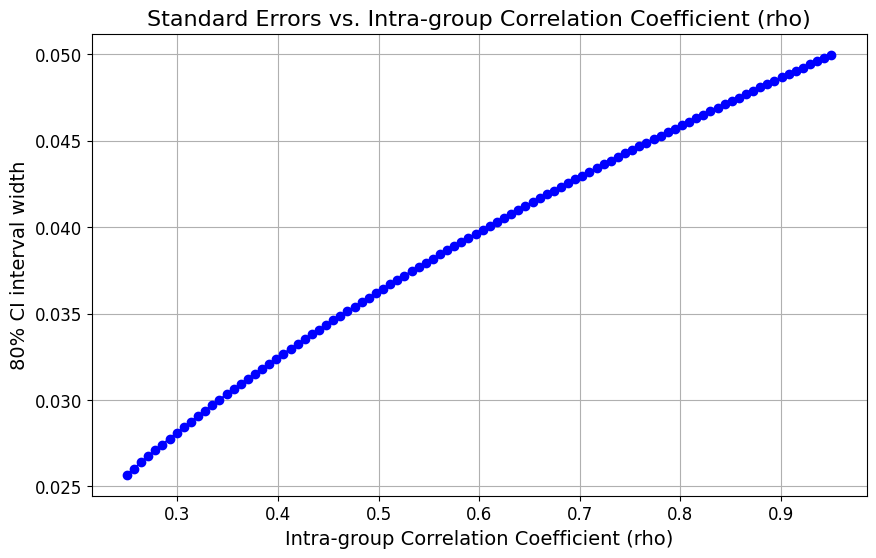

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import math


def calculate_new_se(
    rho, se_original=0.02, G=500, N=500000
):  # suppose they have 1k loss values per training run
    """
    Calculate the new standard error using all observations and accounting for clustering.
    """
    n = N / G  # Number of observations per group
    effective_N = N / (
        1 + (n - 1) * rho
    )  # Effective number of independent observations
    new_se = se_original * math.sqrt(G / effective_N)
    return new_se


# Define rho values from 0.05 to 0.5
rho_values = np.linspace(0.25, 0.95, 100)
new_se_values = [calculate_new_se(rho) for rho in rho_values]
confidence_interval_width = [se * 1.282 * 2 for se in new_se_values]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(rho_values, confidence_interval_width, marker="o", linestyle="-", color="b")
plt.title("Standard Errors vs. Intra-group Correlation Coefficient (rho)")
plt.xlabel("Intra-group Correlation Coefficient (rho)")
plt.ylabel("80% CI interval width")
plt.grid(True)
plt.show()

# Comparing optimal scaling policies

In [49]:
from scipy.stats import multivariate_normal


def scaling_law_reducible(N, D, params):
    a, b, e, alpha, beta = params
    A, B, E = np.exp([a, b, e])

    return A / N**alpha + B / D**beta


def G(params):
    a, b, e, alpha, beta = params
    A, B, E = np.exp([a, b, e])

    return ((alpha * A) / (beta * B)) ** (1 / (alpha + beta))


def compute_optimal_allocation(compute, params):
    a, b, e, alpha, beta = params
    A, B, E = np.exp([a, b, e])

    G = ((alpha * A) / (beta * B)) ** (1 / (alpha + beta))
    a = beta / (alpha + beta)
    b = 1 - a

    return G * (compute / 6) ** a, G ** (-1) * (compute / 6) ** b


def compute_optimal_reducible_loss(compute, params):
    N_opt, D_opt = compute_optimal_allocation(compute, params)
    return scaling_law_reducible(N_opt, D_opt, params)


def optimal_compute_from_reducible_loss(loss, params):
    a, b, e, alpha, beta = params
    A, B, E = np.exp([a, b, e])

    G = ((alpha * A) / (beta * B)) ** (1 / (alpha + beta))
    a = beta / (alpha + beta)
    b = 1 - a

    return 6 * (loss / (G ** (-alpha) * A + G**beta * B)) ** (
        -(alpha + beta) / (alpha * beta)
    )


def compute_optimal_allocation_from_shares(compute, G, a):
    b = 1 - a
    return G * (compute / 6) ** a, G ** (-1) * (compute / 6) ** b


def ratio(params_and_tokens):
    params, tokens = params_and_tokens
    return tokens / params

In [50]:
compute_thresholds = 10 ** np.arange(18, 28, 0.05)
conf_int_percentile = 80
low, high = (100 - conf_int_percentile) / 2, 100 - (100 - conf_int_percentile) / 2

D_N_ratio_conf_int = [[], [], []]
D_N_ratios = []
chinchilla_D_N_ratio = []

compute_loss_factors = []

simulated_params_list = multivariate_normal.rvs(
    mean=estimated_params, cov=cov_matrix[:5, :5], size=10000
)

for threshold in compute_thresholds:
    D_N_ratio = []
    compute_loss_factor = []

    N_true_opt, D_true_opt = compute_optimal_allocation_from_shares(
        threshold, G(true_params), a_mid
    )
    D_N_true_ratio = D_true_opt / N_true_opt

    for simulated_params in simulated_params_list:
        N_opt, D_opt = compute_optimal_allocation(threshold, simulated_params)
        D_N_ratio.append(D_opt / N_opt)

        loss_achieved_by_chinchilla = scaling_law_reducible(
            N_true_opt, D_true_opt, simulated_params
        )
        compute_needed_for_loss = optimal_compute_from_reducible_loss(
            loss_achieved_by_chinchilla, simulated_params
        )

        compute_loss_factor.append(threshold / compute_needed_for_loss)

    D_N_ratio_conf_int[0].append(np.percentile(D_N_ratio, low))
    D_N_ratio_conf_int[1].append(np.median(D_N_ratio))
    D_N_ratio_conf_int[2].append(np.percentile(D_N_ratio, high))

    chinchilla_D_N_ratio.append(D_N_true_ratio)

    D_N_ratios.append(D_N_ratio)
    compute_loss_factors.append(compute_loss_factor)

D_N_ratios = np.array(D_N_ratios)
compute_loss_factors = np.array(compute_loss_factors)

In [51]:
def log_format(val, pos):
    """Format the tick labels on logarithmic scale."""
    val_str = "{:g}".format(val)
    if float(val_str) >= 1.0:
        # If the value is a whole number, return it as an integer.
        return str(int(val))
    else:
        # Otherwise, return the string as is (useful for fractional values).
        return val_str

In [52]:
# Assuming your previous variables and data (compute_thresholds, D_N_ratio_conf_int, etc.) are defined
chinchilla_lower = ratio(
    compute_optimal_allocation_from_shares(compute_thresholds, G(true_params), a_low)
)
chinchilla_upper = ratio(
    compute_optimal_allocation_from_shares(compute_thresholds, G(true_params), a_high)
)

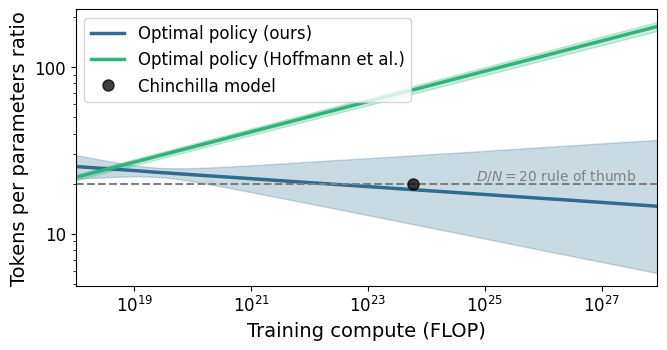

In [53]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

chinchilla_compute = (1.4 * 10**12) * (70 * 10**9) * 6

color_ours = 0.35
color_chinchilla = 0.65

# Define line width for better visibility
line_width = 2.5

plt.figure(figsize=(15 / 2, 7 / 1.85))  # Width: 10 inches, Height: 6 inches

plt.plot(
    compute_thresholds,
    D_N_ratio_conf_int[1],
    label="Optimal policy (ours)",
    color=plt.cm.viridis(color_ours),
    linewidth=line_width,
)
# plt.plot(compute_thresholds, D_N_ratio_conf_int[0], color=plt.cm.viridis(color_ours), linestyle="dashed")
# plt.plot(compute_thresholds, D_N_ratio_conf_int[2], color=plt.cm.viridis(color_ours), linestyle="dashed")

plt.plot(
    compute_thresholds,
    chinchilla_D_N_ratio,
    label="Optimal policy (Hoffmann et al.)",
    color=plt.cm.viridis(color_chinchilla),
    linewidth=line_width,
)
# Assuming chinchilla_lower and chinchilla_upper are defined previously along with their respective function calculations
# plt.plot(compute_thresholds, chinchilla_lower, label="", color=plt.cm.viridis(color_chinchilla), linestyle="dashed")
# plt.plot(compute_thresholds, chinchilla_upper, label="", color=plt.cm.viridis(color_chinchilla), linestyle="dashed")

plt.fill_between(
    compute_thresholds,
    D_N_ratio_conf_int[0],
    D_N_ratio_conf_int[2],
    color=plt.cm.viridis(color_ours),
    alpha=0.25,
    label="",
)
plt.fill_between(
    compute_thresholds,
    chinchilla_lower,
    chinchilla_upper,
    color=plt.cm.viridis(color_chinchilla),
    alpha=0.25,
    label="",
)

plt.axhline(y=20, color="gray", linestyle="--")
plt.text(
    x=7e24,
    y=20,
    s=r"$D/N = 20$ rule of thumb",
    color="gray",
    fontsize=10,
    verticalalignment="bottom",
)

# Adding the round filled marker at (chinchilla_compute, 20)
plt.plot(
    chinchilla_compute,
    20,
    "o",
    color="black",
    markersize=8,
    label="Chinchilla model",
    alpha=0.75,
)  # 'o' is the marker style for a filled circle

plt.xscale("log")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_format))

plt.xlim([min(compute_thresholds), max(compute_thresholds)])
plt.subplots_adjust(bottom=0.15)  # Adjust bottom margin to make space for the x-axis

plt.xlabel("Training compute (FLOP)")
plt.ylabel("Tokens per parameters ratio")
plt.legend(loc="upper left")

plt.savefig("tokens_to_params_ratio_plot.pdf")
plt.show()

In [54]:
import numpy as np

# Assuming compute_thresholds and chinchilla_D_N_ratio are numpy arrays or can be converted into numpy arrays
compute_thresholds = np.array(
    compute_thresholds
)  # Convert to numpy array if not already
chinchilla_D_N_ratio = np.array(
    chinchilla_D_N_ratio
)  # Convert to numpy array if not already

# Calculate the absolute difference between each element in compute_thresholds and chinchilla_compute
abs_difference = np.abs(compute_thresholds - chinchilla_compute)

# Find the index of the smallest difference
index_closest = np.argmin(abs_difference)

# Retrieve and print the value of chinchilla_D_N_ratio at this index
value_closest = chinchilla_D_N_ratio[index_closest]
print(
    f"The value of chinchilla_D_N_ratio closest to chinchilla_compute is: {value_closest}"
)

The value of chinchilla_D_N_ratio closest to chinchilla_compute is: 72.86525718715193


In [55]:
import numpy as np

# Assuming compute_thresholds and chinchilla_D_N_ratio are numpy arrays or can be converted into numpy arrays
compute_thresholds = np.array(
    D_N_ratio_conf_int[1]
)  # Convert to numpy array if not already
chinchilla_D_N_ratio = np.array(
    D_N_ratio_conf_int[1]
)  # Convert to numpy array if not already

# Calculate the absolute difference between each element in compute_thresholds and chinchilla_compute
abs_difference = np.abs(compute_thresholds - chinchilla_compute)

# Find the index of the smallest difference
index_closest = np.argmin(abs_difference)

# Retrieve and print the value of chinchilla_D_N_ratio at this index
value_closest = chinchilla_D_N_ratio[index_closest]
print(
    f"The value of chinchilla_D_N_ratio closest to chinchilla_compute is: {value_closest}"
)

The value of chinchilla_D_N_ratio closest to chinchilla_compute is: 25.342625656355168


# Replicate with lower loss scale

In [56]:
import autograd.numpy as np
from autograd.scipy.stats import norm
from scipy.optimize import minimize
from scipy.special import erf

true_params = np.array([np.log(406.4), np.log(410.7), np.log(1.69), 0.34, 0.28])


# Define the log-sum-exp function
def log_sum_exp(a, b, e, alpha, beta, N, D):
    return np.log(
        np.exp(a - alpha * np.log(N)) + np.exp(b - beta * np.log(D)) + np.exp(e)
    )


# Define the Huber loss function
def custom_huber_loss(y_true, y_pred, delta=1e-3, reduce_fn=np.sum):
    # Calculate the difference
    diff = y_true - y_pred
    # Calculate the condition for Huber loss
    cond = np.abs(diff) <= delta
    # Apply Huber loss formula
    loss = np.where(cond, 0.5 * diff**2, delta * (np.abs(diff) - 0.5 * delta))
    return reduce_fn(loss)


def huber_normalizing_factor(delta=1e-3):
    return (
        np.sqrt(2 * np.pi) * (1 - 2 * norm.sf(delta))
        + 2 * np.exp(-0.5 * delta**2) / delta
    )


def huber_logpdf(x, delta=1e-3, loc=0, scale=1):
    x = (x - loc) / scale

    cond = np.abs(x) <= delta
    loss = np.where(cond, 0.5 * x**2, delta * (np.abs(x) - 0.5 * delta))
    return -loss - np.log(huber_normalizing_factor(delta=delta)) - np.log(scale)


def huber_pdf(x, delta=1e-3, loc=0, scale=1):
    return np.exp(huber_logpdf(x, delta=delta, loc=loc, scale=scale))


# Define the objective function to be minimized
def objective(params, N, D, losses):
    a, b, e, alpha, beta, sigma = params
    predictions = log_sum_exp(a, b, e, alpha, beta, N, D)
    return -np.sum(
        huber_logpdf(np.log(losses), loc=predictions, scale=np.exp(sigma), delta=1e-3)
    )
    # return custom_huber_loss(np.log(losses), predictions, delta=1e-3)


def scale_objective(sigma, params, N, D, losses):
    a, b, e, alpha, beta = params
    predictions = log_sum_exp(a, b, e, alpha, beta, N, D)
    return -np.sum(
        huber_logpdf(np.log(losses), loc=predictions, scale=np.exp(sigma), delta=1e-3)
    )
    # return custom_huber_loss(np.log(losses), predictions, delta=1e-3)


def constant_term_objective(params, a, b, alpha, beta, N, D, losses):
    e, sigma = params
    predictions = log_sum_exp(a, b, e, alpha, beta, N, D)
    return -np.sum(
        huber_logpdf(np.log(losses), loc=predictions, scale=np.exp(sigma), delta=1e-3)
    )


def huber_loss_objective(params, N, D, losses, reduce_fn=np.sum):
    a, b, e, alpha, beta = params
    predictions = log_sum_exp(a, b, e, alpha, beta, N, D)
    return custom_huber_loss(
        np.log(losses), predictions, delta=1e-3, reduce_fn=reduce_fn
    )


# Define the parameter untransform
def untransform_params(param_array):
    if len(np.shape(param_array)) == 2:
        return np.hstack((np.exp(param_array[:, :3]), param_array[:, 3:]))
    else:
        return np.hstack((np.exp(param_array[:3]), param_array[3:]))


# Define the Huber loss function on residuals
def huber_loss(residuals, delta=1e-3):
    # Calculate the difference
    diff = residuals
    # Calculate the condition for Huber loss
    cond = np.abs(diff) <= delta
    # Apply Huber loss formula
    loss = np.where(cond, 0.5 * diff**2, delta * (np.abs(diff) - 0.5 * delta))
    return loss

In [57]:
import functools

# Set up the grid for initial parameter values
alpha_vals = np.linspace(0.0, 2.0, 10)
beta_vals = np.arange(0, 2.5, 0.5)
e_vals = np.linspace(0.0, 2.0, 10)
a_vals = np.linspace(6, 30, 10)
b_vals = np.arange(0, 30, 5)

# Perform the optimization using L-BFGS over the grid of initial values
best_loss = np.inf
best_params = None

from itertools import product

results_dict = {}
for alpha, e, a in product(alpha_vals, e_vals, a_vals):
    init_params = [a, a, e, alpha, alpha]
    result = minimize(
        functools.partial(huber_loss_objective, reduce_fn=np.sum),
        init_params,
        args=(N[indices], D[indices], losses[indices]),
        method="L-BFGS-B",
    )
    # print(result.message)
    results_dict[tuple(init_params)] = {"params": result.x, "loss": result.fun}
    if result.success and result.fun < best_loss:
        best_loss = result.fun
        best_params = result.x
        print(f"New best loss: {best_loss}")
        print(f"Best params: {best_params}")
        print(f"Initial guess: {init_params}")

# Transform the fitted parameters a, b, e to A, B, E
if best_params is not None:
    A = np.exp(best_params[0])
    B = np.exp(best_params[1])
    E = np.exp(best_params[2])
    alpha = best_params[3]
    beta = best_params[4]
    print(f"Best fit parameters: A={A}, B={B}, E={E}, alpha={alpha}, beta={beta}")
else:
    print("Optimization failed to converge.")

A = np.exp(true_params[0])
B = np.exp(true_params[1])
E = np.exp(true_params[2])
alpha = true_params[3]
beta = true_params[4]
print(
    f"\nParameters from Chinchilla paper: A={A}, B={B}, E={E}, alpha={alpha}, beta={beta}"
)

New best loss: 0.011308204420138843
Best params: [5.99162188 5.96163337 0.70553144 0.32064744 0.904284  ]
Initial guess: [6.0, 6.0, 0.0, 0.0, 0.0]
New best loss: 0.010857956703885126
Best params: [7.46530651 8.6465501  0.77675785 0.40747624 0.50581228]
Initial guess: [8.666666666666666, 8.666666666666666, 0.0, 0.0, 0.0]
New best loss: 0.0010358248405590222
Best params: [6.25977334 7.43039585 0.59228147 0.35263008 0.35528789]
Initial guess: [14.0, 14.0, 0.0, 0.0, 0.0]
New best loss: 0.0010353965394113316
Best params: [6.12013575 7.55835793 0.59014823 0.34417807 0.36174924]
Initial guess: [11.333333333333332, 11.333333333333332, 1.1111111111111112, 0.0, 0.0]
New best loss: 0.0010349765700634647
Best params: [6.17420628 7.50395794 0.59090205 0.34745066 0.3590149 ]
Initial guess: [11.333333333333332, 11.333333333333332, 1.5555555555555554, 0.0, 0.0]
New best loss: 0.0010349745866340397
Best params: [6.17348306 7.50762022 0.59097802 0.34740948 0.35919281]
Initial guess: [14.0, 14.0, 1.77777

Show effect of lower loss scale

In [58]:
import autograd.numpy as np
from autograd.scipy.stats import norm
from scipy.optimize import minimize
from scipy.special import erf

# true_params = np.array([np.log(406.4), np.log(410.7), np.log(1.69), 0.34, 0.28])
true_params = np.array([6.0073404, 6.0179186, 0.5267228, 0.33917084, 0.2849083])
true_params_rounded = np.array([np.log(406.4), np.log(410.7), np.log(1.69), 0.34, 0.28])


# Define the log-sum-exp function
def log_sum_exp(a, b, e, alpha, beta, N, D):
    return np.log(
        np.exp(a - alpha * np.log(N)) + np.exp(b - beta * np.log(D)) + np.exp(e)
    )


# Define the Huber loss function
def custom_huber_loss_sum(y_true, y_pred, delta=1e-3):
    # Calculate the difference
    diff = y_true - y_pred
    # Calculate the condition for Huber loss
    cond = np.abs(diff) <= delta
    # Apply Huber loss formula
    loss = np.where(cond, 0.5 * diff**2, delta * (np.abs(diff) - 0.5 * delta))
    return np.sum(loss)


def huber_loss_objective_sum(params, N, D, losses):
    a, b, e, alpha, beta = params
    predictions = log_sum_exp(a, b, e, alpha, beta, N, D)
    return custom_huber_loss_sum(np.log(losses), predictions, delta=1e-3)


# Define the Huber loss function
def custom_huber_loss_mean(y_true, y_pred, delta=1e-3):
    # Calculate the difference
    diff = y_true - y_pred
    # Calculate the condition for Huber loss
    cond = np.abs(diff) <= delta
    # Apply Huber loss formula
    loss = np.where(cond, 0.5 * diff**2, delta * (np.abs(diff) - 0.5 * delta))
    return np.mean(loss)


def huber_loss_objective_mean(params, N, D, losses):
    a, b, e, alpha, beta = params
    predictions = log_sum_exp(a, b, e, alpha, beta, N, D)
    return custom_huber_loss_mean(np.log(losses), predictions, delta=1e-3)

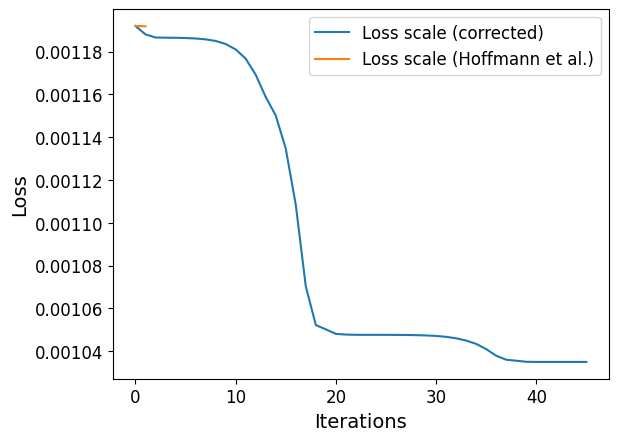

In [59]:
# Initialize parameters
init_params = list(true_params)

# Store loss values
sum_loss_values_for_sum_opt = []
sum_loss_values_for_mean_opt = []


# Callback functions to log loss values
def callback_sum(params):
    sum_loss = huber_loss_objective_sum(params, N[indices], D[indices], losses[indices])
    sum_loss_values_for_sum_opt.append(sum_loss)


def callback_mean(params):
    # Calculate the sum loss even though the mean loss is being optimized
    sum_loss = huber_loss_objective_sum(params, N[indices], D[indices], losses[indices])
    sum_loss_values_for_mean_opt.append(sum_loss)


# Perform optimization with logging
result_sum = minimize(
    huber_loss_objective_sum,
    init_params,
    args=(N[indices], D[indices], losses[indices]),
    jac=grad(huber_loss_objective_sum),
    method="BFGS",
    callback=callback_sum,
)

init_params = list(true_params)
result_mean = minimize(
    huber_loss_objective_mean,
    init_params,
    args=(N[indices], D[indices], losses[indices]),
    method="L-BFGS-B",
    callback=callback_mean,
)

# Plotting the loss values
plt.plot(sum_loss_values_for_sum_opt, label="Loss scale (corrected)")
plt.plot(sum_loss_values_for_mean_opt, label="Loss scale (Hoffmann et al.)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
# plt.title('Sum Loss vs. Iterations')
plt.show()